<a href="https://colab.research.google.com/github/DavorJordacevic/KERAS-NEURAL-NETWORKS/blob/master/Convolutional_neural_network_with_Keras_dogs_vs_cats_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving a dogs-vs-cats classification problem- Convolutional neural network with Keras

Author: Davor Jordačević

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano.

In [0]:
import os
import cv2
import keras
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings("ignore")
K.set_image_data_format('channels_last')

Using TensorFlow backend.


# 1. Using Kaggle datasets in Google Colab

**Kaggle** is an online community of data scientists and machine learners, owned by Google, Inc. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

Tutorial: Kaggle API + Google Colaboratory: 


*   https://www.kaggle.com/general/51898
*   https://www.kaggle.com/general/74235
*   https://stackoverflow.com/questions/49310470/using-kaggle-datasets-into-google-colab



In [0]:
# The combination of user and the key is unique
# This parametars can be found in kaggle.json file which can
# be downloaded from kaggle
user = "__________________"
key  = "__________________"

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 73 Feb 14 17:03 kaggle.json
{"username":"davorjordacevic97","key":"3d1dd9afd392eac6a3b88ca53a93ee6b"}

Install kaggle packages

In [0]:
!pip install -q kaggle
!pip install -q kaggle-cli

    100% |████████████████████████████████| 81kB 3.2MB/s 
    100% |████████████████████████████████| 5.3MB 6.1MB/s 
    100% |████████████████████████████████| 92kB 26.2MB/s 
    100% |████████████████████████████████| 51kB 20.1MB/s 


List files in a dataset /competition using string pattern

In [0]:
!kaggle competitions list -s dogs-vs-cats

ref                                 deadline             category       reward  teamCount  userHasEntered  
----------------------------------  -------------------  ----------  ---------  ---------  --------------  
dogs-vs-cats                        2014-02-01 23:59:00  Playground       Swag        215            True  
dogs-vs-cats-redux-kernels-edition  2017-03-02 23:59:00  Playground  Knowledge       1314           False  


For the purpose of classification, we will download the data from kaggle and
store in an appropriate format.

In [0]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 65.4MB/s]
 98% 267M/271M [00:05<00:00, 55.2MB/s]
100% 271M/271M [00:05<00:00, 53.4MB/s]
 98% 535M/543M [00:15<00:00, 25.9MB/s]
100% 543M/543M [00:16<00:00, 35.5MB/s]


# 2. Unzip data

The first step is to unzip data

In [0]:
import zipfile

with zipfile.ZipFile("train.zip","r") as zip_ref:
    zip_ref.extractall("dataset")
with zipfile.ZipFile("test1.zip","r") as zip_ref:
    zip_ref.extractall("dataset")

# 3. Preparing the data

We will use only
a portion of the data to train a model.

We will use only 1,000 images of cats and dogs. 

Copy images 0–999 from the unziped folder to the newly created
train folder under cats and  copy 1,000–1,400 to data/test/cat . Similarly, copy 0–999 in
train/dogs and 1,000–1,400 in data/test/dog so that we have 1,000 training
examples for each class and 400 validation examples for each class.

In [0]:
import os
import shutil
work_dir = '/content/dataset/'
image_names = sorted(os.listdir(os.path.join(work_dir, 'train')))
def copy_files(prefix_str, range_start, range_end, target_dir):
  image_paths = [os.path.join(work_dir, 'train', prefix_str + '.' + str(i) + '.jpg')
                 for i in range(range_start, range_end)]
  dest_dir = os.path.join(work_dir, target_dir, prefix_str)
  os.makedirs(dest_dir)
  for image_path in image_paths:
    shutil.copy(image_path, dest_dir) 
copy_files('dog',0, 1000, 'copy_train')
copy_files('cat',0, 1000, 'copy_train')
copy_files('dog',1000, 1400, 'copy_test')
copy_files('cat',1000, 1400, 'copy_test')

# 4. Implementing a Neural Network

### 4.1 Define the parameters

In [0]:
image_height, image_width = 150, 150
# we need to define train and test directory for later use
train_dir = os.path.join(work_dir, 'copy_train')
test_dir = os.path.join(work_dir, 'copy_test')
# the number of classes we have
no_classes = 2
no_validation = 800
epochs = 10
batch_size = 200
no_train = 2000
no_test = 800
input_shape = (image_height, image_width, 3)
epoch_steps = no_train // batch_size
test_steps = no_test // batch_size

### 4.2 ImageDataGenerator

It's better to load only a batch of images at a
time for training and testing. For this purpose, a Keras has a class called
ImageDataGenerator that reads images whenever necessary. We also need to rescale the images for better results.

The following is an
example of using a generator for loading the images:

In [0]:
generator_train = ImageDataGenerator(rescale = 1./255)

generator_test = ImageDataGenerator(rescale = 1./255)

### 4.3 Flow_from_directory

We can read the images from the directory using the flow_from_directory method as follows:

In [0]:
training_set = generator_train.flow_from_directory(train_dir,
                                     target_size = (image_height, image_width),
                                     batch_size = 32,
                                     class_mode = 'binary')

test_set = generator_test.flow_from_directory(test_dir,
                                     target_size =(image_height, image_width),
                                     batch_size = 32,
                                     class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### 4.4 Simple Convolutional Neural Network model

In [0]:
def create_model(shape):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape = shape, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Conv2D(32, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dropout(0.3))
  
  model.add(Dense(units = 256, activation = 'relu'))
  model.add(Dense(units = 1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

simple_cnn_model = create_model(input_shape)
simple_cnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)  

### 4.5 Train the model

Let's trains the model for a given number of epochs.

In [0]:
results = simple_cnn_model.fit_generator(
      training_set,
      steps_per_epoch=epoch_steps,
      epochs=epochs,
      validation_data=test_set,
      validation_steps=test_steps
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
10/10 [==============================] - 7s 686ms/step - loss: 0.9437 - acc: 0.4562 - val_loss: 0.6984 - val_acc: 0.4531
Epoch 2/10
10/10 [==============================] - 1s 97ms/step - loss: 0.6923 - acc: 0.5062 - val_loss: 0.6963 - val_acc: 0.5078
Epoch 3/10
10/10 [==============================] - 2s 152ms/step - loss: 0.6908 - acc: 0.5531 - val_loss: 0.6901 - val_acc: 0.5312
Epoch 4/10
10/10 [==============================] - 1s 148ms/step - loss: 0.6902 - acc: 0.5187 - val_loss: 0.6774 - val_acc: 0.6172
Epoch 5/10
10/10 [==============================] - 1s 145ms/step - loss: 0.6767 - acc: 0.5938 - val_loss: 0.6942 - val_acc: 0.5234
Epoch 6/10
10/10 [==============================] - 1s 148ms/step - loss: 0.6806 - acc: 0.5656 - val_loss: 0.6927 - val_acc: 0.6016
Epoch 7/10
10/10 [==============================] - 2s 150ms/step - loss: 0.6484 - acc: 0.6250 - val_loss: 0.6774 - val_acc: 0.5234
Epoch 8/10
10/10 [===========

### 4.6 Test the model

Model can generate output predictions for the input samples.

In [0]:
simple_cnn_model.predict_generator(generator=test_set, 
                        steps=len(test_set), 
                        workers=1, 
                        use_multiprocessing=False, 
                        verbose=1
);

25/25 [==============================] - 3s 111ms/step


### 4.7 Accuracy

Test-Accuracy :

In [0]:
print("Test-Accuracy:","%.2f%%" % (np.mean(results.history["val_acc"])*100))

Test-Accuracy: 55.70%


### 4.8 Evaluate the model to see the accuracy

Now we can check the accuracy of our model

Maximum Loss : 0.9437
Minimum Loss : 0.6085
Loss difference : 0.3352


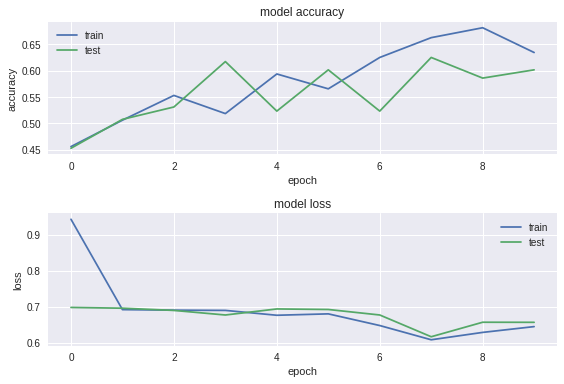

In [0]:
# summarize history for accuracy
plt.subplot(211)
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='down right')

# summarize history for loss
plt.subplot(212)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='down right')
plt.tight_layout()

max_loss = np.max(results.history['loss'])
min_loss = np.min(results.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("Minimum Loss : {:.4f}".format(min_loss))
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

# 5. Augmenting the dataset

Data augmentation gives ways to increase the size of the dataset. Data
augmentation introduces noise during training, producing robustness in the
model to various inputs.

There are various ways to augment the images. All these techniques are implemented in ImageDataGenerator to increase the dataset
size.

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/10
 - 4s - loss: 1.4321 - acc: 0.5250 - val_loss: 0.6974 - val_acc: 0.4844
Epoch 2/10
 - 3s - loss: 0.6893 - acc: 0.5469 - val_loss: 0.6971 - val_acc: 0.4688
Epoch 3/10
 - 3s - loss: 0.7055 - acc: 0.4719 - val_loss: 0.6961 - val_acc: 0.4844
Epoch 4/10
 - 3s - loss: 0.6895 - acc: 0.5500 - val_loss: 0.6919 - val_acc: 0.5547
Epoch 5/10
 - 3s - loss: 0.6925 - acc: 0.5000 - val_loss: 0.6803 - val_acc: 0.5469
Epoch 6/10
 - 3s - loss: 0.6954 - acc: 0.4531 - val_loss: 0.6842 - val_acc: 0.5938
Epoch 7/10
 - 3s - loss: 0.6903 - acc: 0.5973 - val_loss: 0.6888 - val_acc: 0.5703
Epoch 8/10
 - 3s - loss: 0.6898 - acc: 0.5625 - val_loss: 0.6888 - val_acc: 0.5469
Epoch 9/10
 - 3s - loss: 0.6866 - acc: 0.5563 - val_loss: 0.6692 - val_acc: 0.5781
Epoch 10/10
 - 3s - loss: 0.6741 - acc: 0.5781 - val_loss: 0.6894 - val_acc: 0.6094
Test-Accuracy: 54.37%

Maximum Loss : 1.4321
Minimum Loss : 0.6741
Loss difference : 0

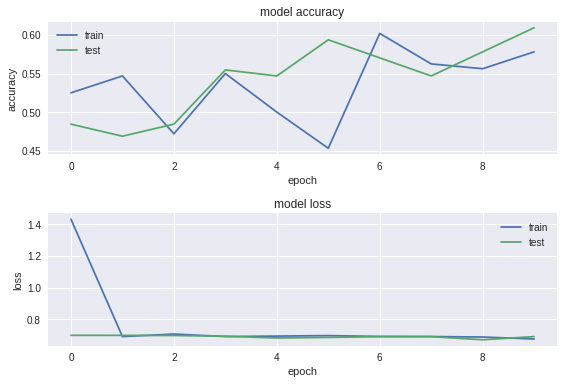

In [0]:
generator_train = ImageDataGenerator(
  rescale=1. / 255,
  horizontal_flip=True,
  zoom_range=0.2,
  shear_range=0.2,
  rotation_range=45,
  width_shift_range=0.2,
  height_shift_range=0.2,
)
generator_test = ImageDataGenerator(rescale=1./255)

training_set = generator_train.flow_from_directory(train_dir,
   target_size = (image_height, image_width),
   batch_size = 32,
   class_mode = 'binary'
)
test_set = generator_test.flow_from_directory(test_dir,
   target_size =(image_height, image_width),
   batch_size = 32,
   class_mode = 'binary'
)

simple_cnn_model = create_model(input_shape)

results = simple_cnn_model.fit_generator(
      training_set,
      steps_per_epoch=epoch_steps,
      epochs=epochs,
      validation_data=test_set,
      validation_steps=test_steps,
      verbose = 2
)

print("Test-Accuracy:","%.2f%%\n" % (np.mean(results.history["val_acc"])*100))

# summarize history for accuracy
plt.subplot(211)
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='down right')

# summarize history for loss
plt.subplot(212)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='down right')
plt.tight_layout()

max_loss = np.max(results.history['loss'])
min_loss = np.min(results.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("Minimum Loss : {:.4f}".format(min_loss))
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

# 6. Transfer learning or fine-tuning of a model

# Training on bottleneck features

**VGG16 model**

![alt text](https://www.researchgate.net/profile/Kasthurirangan_Gopalakrishnan/publication/319952138/figure/fig2/AS:613973590282251@1523394119133/A-schematic-of-the-VGG-16-Deep-Convolutional-Neural-Network-DCNN-architecture-trained.png)

In [0]:
top_model_weights_path = 'bottleneck_fc_model.h5'  

### 6.1 Extract the bottleneck layers 

Extract the bottleneck layers as
follows:

In [0]:
model = keras.applications.VGG16(include_top=False)

generator = ImageDataGenerator(rescale=1. / 255)

train_images = generator.flow_from_directory(
  train_dir,
  batch_size=batch_size,
  target_size=(image_width, image_height),
  class_mode=None,
  shuffle=False
)
train_bottleneck_features = model.predict_generator(train_images, epoch_steps)
np.save('train_bottleneck_features.npy', train_bottleneck_features)  

test_images = generator.flow_from_directory(
  test_dir,
  batch_size=batch_size,
  target_size=(image_width, image_height),
  class_mode=None,
  shuffle=False
)
test_bottleneck_features = model.predict_generator(test_images, test_steps)
np.save('test_bottleneck_features.npy', test_bottleneck_features)

58892288/58889256 [==============================] - 5s 0us/step
Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### 6.2 Assign the labels

The VGG model is taken and used to predict the images. The labels are assigned
as follows:


In [0]:
train_labels = np.array([0] * int(no_train / 2) + [1] * int(no_train / 2))
test_labels = np.array([0] * int(no_test / 2) + [1] * int(no_test / 2))

### 6.3 Build a Sequential model

A sequential model with a couple of layers is built, compiled, and trained with
the bottleneck features and can be implemented using the code given as follows:

In [0]:
model = Sequential()
model.add(Flatten(input_shape=train_bottleneck_features.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### 6.4 Train the model

In [0]:
results = model.fit(
  train_bottleneck_features,
  train_labels,
  batch_size=batch_size,
  epochs=20,
  validation_data=(test_bottleneck_features, test_labels)
)

Train on 2000 samples, validate on 800 samples
Epoch 1/20
2000/2000 [==============================] - 1s 642us/step - loss: 1.0962 - acc: 0.6910 - val_loss: 0.3275 - val_acc: 0.8625
Epoch 2/20
2000/2000 [==============================] - 0s 114us/step - loss: 0.2974 - acc: 0.8660 - val_loss: 0.2652 - val_acc: 0.8975
Epoch 3/20
2000/2000 [==============================] - 0s 111us/step - loss: 0.2120 - acc: 0.9150 - val_loss: 0.2444 - val_acc: 0.9025
Epoch 4/20
2000/2000 [==============================] - 0s 114us/step - loss: 0.1735 - acc: 0.9345 - val_loss: 0.2479 - val_acc: 0.8950
Epoch 5/20
2000/2000 [==============================] - 0s 112us/step - loss: 0.1485 - acc: 0.9460 - val_loss: 0.2465 - val_acc: 0.8975
Epoch 6/20
2000/2000 [==============================] - 0s 109us/step - loss: 0.1130 - acc: 0.9630 - val_loss: 0.2564 - val_acc: 0.8987
Epoch 7/20
2000/2000 [==============================] - 0s 110us/step - loss: 0.0962 - acc: 0.9715 - val_loss: 0.2349 - val_acc: 0.9062
E

### 6.5 Save weights: 

In [0]:
 model.save_weights(top_model_weights_path)  

### 6.6 Accuracy

Test-Accuracy :

In [0]:
print("Test-Accuracy:","%.2f%%\n" % (np.mean(results.history["val_acc"])*100))

Test-Accuracy: 90.08%



### 6.7 Evaluate the model to see the accuracy

Maximum Loss : 1.0962
Minimum Loss : 0.0094
Loss difference : 1.0869


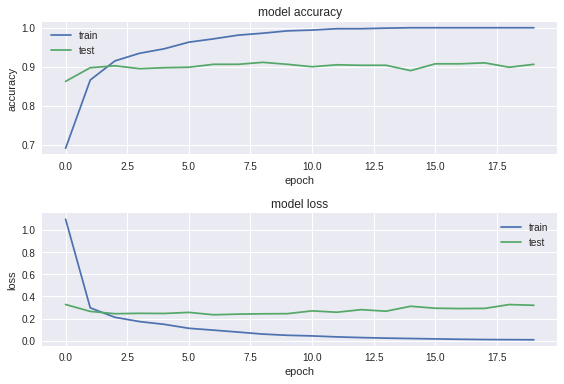

In [0]:
# summarize history for accuracy
plt.subplot(211)
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='down right')

# summarize history for loss
plt.subplot(212)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='down right')
plt.tight_layout()

max_loss = np.max(results.history['loss'])
min_loss = np.min(results.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("Minimum Loss : {:.4f}".format(min_loss))
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1025      
Total params: 8,390,657
Trainable params: 8,390,657
Non-trainable params: 0
_________________________________________________________________


### 6.8 Class Predictions

In [0]:
predictions = model.predict_classes(test_bottleneck_features)
predictions = predictions.reshape((predictions.shape[0]))
filenames=test_images.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

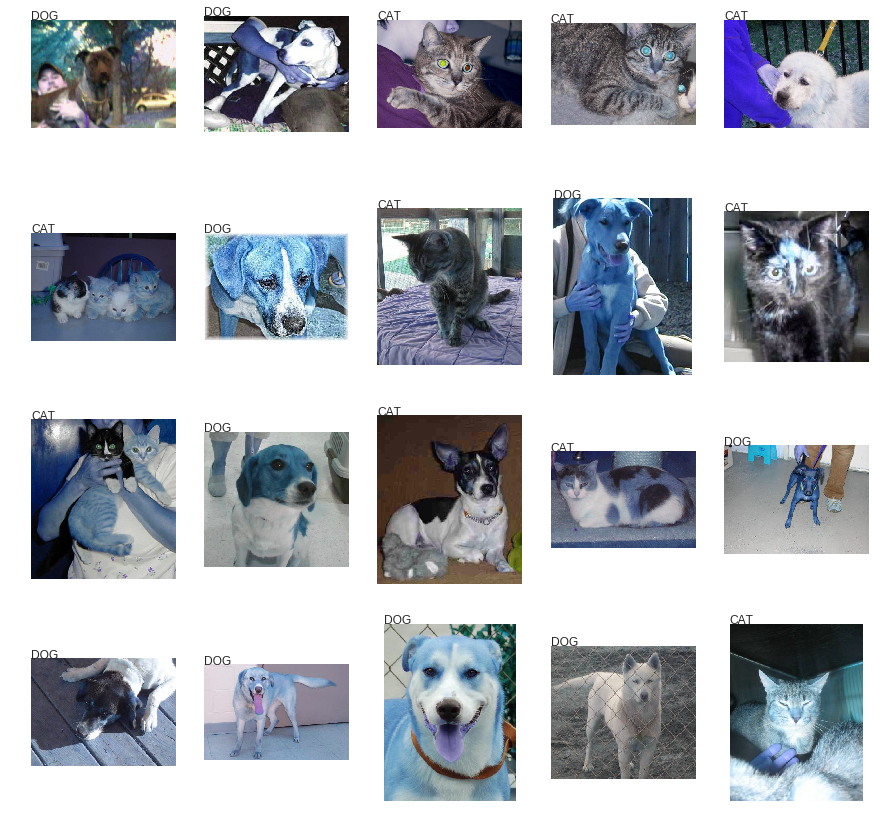

In [0]:
i = 0
plt.figure(figsize=(15,15))
sample = results.sample(20)

for index, row in sample.iterrows():
  image_path = "/content/dataset/copy_test/" + row["Filename"]
  orig  = cv2.imread(image_path)
 
  plt.subplot(4,5,i+1)
  plt.imshow(orig)
  if row["Predictions"] == 0:
    plt.text(0, 0,'CAT')
  else:
    plt.text(0, 0,'DOG')
  plt.grid('off')
  plt.axis('off')
  i += 1 

# 7. Test our model

### 7.1 Import files

In google colab we can import files through the following commands:

In [0]:
_r1 = !wget "https://images.freeimages.com/images/large-previews/63d/dog-1383055.jpg" 
_r2 = !wget "https://images.freeimages.com/images/large-previews/bd1/cat-1404368.jpg"

### 7.2 Define a function

Now we can define a function for testing our model

In [0]:
def test_model(image_path):
  orig  = cv2.imread(image_path)  
  orig  = cv2.resize(orig,(150,150))
  orig  = np.expand_dims(orig, axis=0)
  model_vgg16 = keras.applications.VGG16(include_top=False)
  bottleneck_prediction = model_vgg16.predict(orig)
  model_vgg16 = Sequential()
  model_vgg16.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
  model_vgg16.add(Dense(1024, activation='relu'))
  model_vgg16.add(Dropout(0.3))
  model_vgg16.add(Dense(1, activation='sigmoid'))
  model_vgg16.load_weights(top_model_weights_path)
  class_predicted = model_vgg16.predict_classes(bottleneck_prediction)

  plt.imshow(orig.reshape(150,150,3))
  plt.grid('off')
  plt.axis('off')
  if class_predicted[0,0] == 0:
    print('Predicted: cat')
  else:
    print('Predicted: dog')

### 7.3 Test out model on imported images:

Predicted: dog


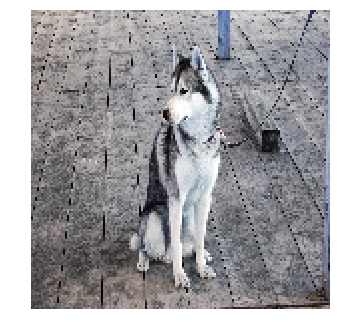

In [0]:
image_path = "/content/dog-1383055.jpg"
test_model(image_path)

Predicted: cat


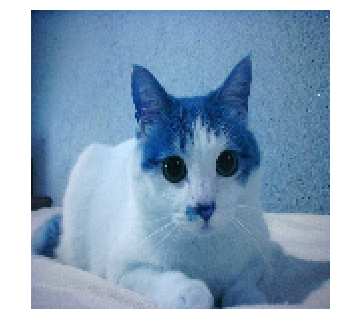

In [0]:
image_path = "/content/cat-1404368.jpg"
test_model(image_path)

# 8. Save a model as picture

### 8.1 Save a model as png picture

In [0]:
from keras.utils import plot_model

plot_model(keras.applications.VGG16(include_top=False),show_shapes=True,
           show_layer_names=False, to_file='modelVGG16.png')
plot_model(model,show_shapes=True,show_layer_names=False, to_file='model.png')



---



---

For more informations, visit http://datahacker.rs/ .

For more examples, visit https://github.com/DavorJordacevic.


---



---